## Giới thiệu về bộ dữ liệu sẽ xử lý

- Bộ dữ liệu raw bao gồm 4 file `laptop_basic.csv`, `laptop_detail.csv`, `cpuben.csv` và `cpuben.csv`. Dữ liệu được cào từ website [LaptopMedia](https://laptopmedia.com/)
- File `laptop_basic.csv` chứa link thông tin của 10000 laptop.
- File `laptop_detail.csv` chứa thông tin chi tiết của 10000 laptop.
- File `cpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 122 mẫu CPU.
- File `gpuben.csv` chứa thông tin benchmark và thứ hạng hiệu năng của 140 mẫu GPU.
- Trong notebook này, chúng em sẽ tiến hành gộp, xử lý và làm sạch dữ liệu. Kết quả cuối cùng sẽ được lưu vào file 'clean_data.csv' 

## 1. Khai báo thư viện


In [70]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 2. Load và kiểm tra tập dữ liệu thô

In [71]:
data_detail = pd.read_csv('raw10k\laptop_detail.csv')
print('Number of rows and columns:', data_detail.shape)

Number of rows and columns: (10000, 97)


In [72]:
data_detail.head(3)

,Unnamed: 0.1,Unnamed: 0,Product Name,Product Link,Processor,Internal memory,Video card,Display,Solid-state drive,Price,...,Storage drive heater\n,4G LTE multi carrier mobile broadband with satellite GPS,E-compass\n,Accelerometer,4x RAM slots,G-sensor,Accelerometer (G-sensor),Slot Integrated Bluetooth Earbuds,3W subwoofer,MIL-STD 810G tested
0,0,0,ASUS TUF Dash F15,https://laptopmedia.com/laptop-specs/asus-tuf-...,Intel Core i7-12650H,64GB RAM,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$362900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Lenovo Legion 5i 15,https://laptopmedia.com/laptop-specs/lenovo-le...,Intel Core i7-12700H,64GB RAM,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$304999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Acer Nitro 5,https://laptopmedia.com/laptop-specs/acer-nitr...,Intel Core i7-12700H,32GB RAM,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$181900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
col_nan_count = data_detail.isnull().sum()
# count number of columns with missing values
print('Number of columns with missing values:', len(col_nan_count[col_nan_count > 0]))

Number of columns with missing values: 89


## 3. Làm sạch dữ liệu

### 3.1 Xóa hai cột thông tin dư đầu tiên
Hai cột đầu tiên không chứa thông tin liên quan nên sẽ được xóa bỏ.

In [74]:
# delete the first two column
data_detail = data_detail.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

### 3.2 Xóa các cột thông tin chứa quá nhiều dữ liệu trống


#### 3.2.1 Take a look at the data


In [75]:
print('Top 25 cột có nhiều giá trị non-null nhất:')
data_detail.count().sort_values(ascending=False)[:25]

Top 25 cột có nhiều giá trị non-null nhất:


Product Name          10000
Processor             10000
Internal memory       10000
Video card            10000
Product Link          10000
Price                 10000
GPU                    9999
Features               9999
Weight                 9999
RAM                    9998
Detail price           9997
HDD/SSD                9996
Display                9985
OS                     9975
Dimensions             9950
Solid-state drive      9866
Web camera             9237
Speakers               8977
Microphone             7443
Gifts                  6504
Body Material          4639
M.2 Slot               4561
Security Lock slot     2283
Hard drive              688
Fingerprint reader       53
dtype: int64

In [76]:
# Get top 25 columns with the less non-null values
print('Top 25 cột có ít giá trị non-null nhất:')
data_detail.count().sort_values(ascending=True)[:25]

Top 25 cột có ít giá trị non-null nhất:


MIL-STD-810G military certification                                                           0
NOVO hole                                                                                     0
IR face recognition (optional), fingerprint reader (optional), backlit keyboard (optional)    0
Gyroscope                                                                                     0
Hall Sensor\n                                                                                 0
Accelerometer sensor\n                                                                        0
12.65" ScreenPad Plus (1920 x 515, IPS, with stylus support)                                  0
Optane H10 disk-acceleration                                                                  0
HP Premium Spill-resistant Keyboard                                                           0
MIL-STD-810G                                                                                  0
Touch Bar\n                             

- Với cột 'Hard drive' các dữ liệu trống sẽ được thay thế bằng '0 GB' để dễ xử lý và sử dụng sau này. Điều này khớp với thực tế vì các laptop

In [77]:
# fill missing value in Hard drive with 0GB
# data_detail['Hard drive'] = data_detail['Hard drive'].fillna('0GB')

#### 3.2.2 Xóa các cột thông tin chứa không quá 20% dữ liệu là dữ liệu không trống


In [78]:
def filter_column_meaningless(df, percent=0.80):
    filtered_column = []
    for column in df.columns:
        if (df[column].notnull().sum() <= percent * df.shape[0]):
            filtered_column.append(column)
    return filtered_column

In [79]:
useless_column = filter_column_meaningless(data_detail)

In [80]:
# pritn shape of Microphone column
print('Shape of Microphone column:', data_detail['Microphone'].shape)

Shape of Microphone column: (10000,)


In [81]:
data_detail['Microphone'].value_counts()

Microphone
Dual Array Digital Microphone                     926
Dual Array Microphone                             835
Dual Array Digital Microphones                    717
Array Microphone with AI Noise Cancelling         450
Dual-Array Microphone                             399
                                                 ... 
Digital dual-array microphone                       1
Dual Far Field Microphones                          1
4x Noise reducing integrated array microphones      1
Four Array Microphones, 360° Far Field              1
4 Array Far-Field Digital Microphones               1
Name: count, Length: 143, dtype: int64

77


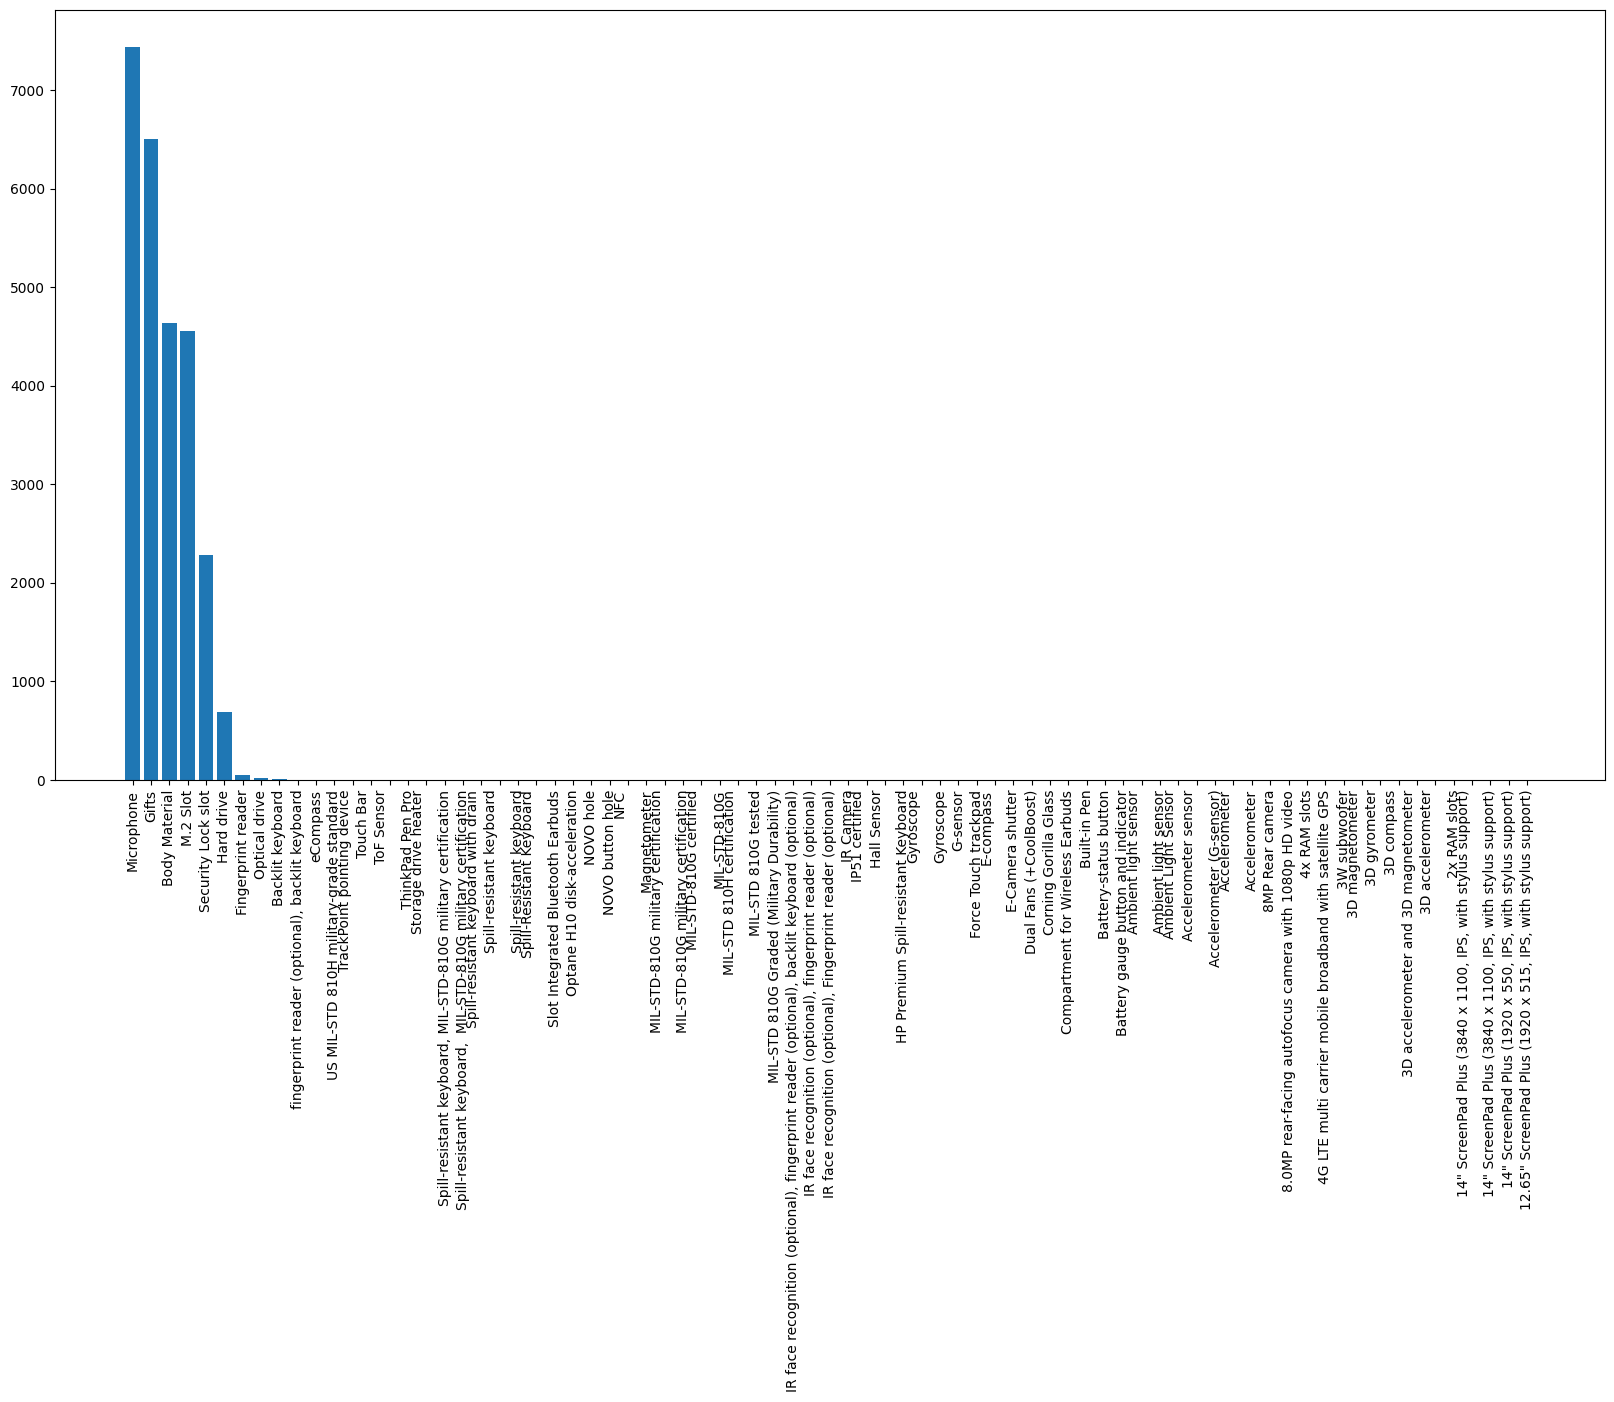

In [82]:
# print the name and number of non-null values of useless columns
print(len(useless_column))
useless_column_count = []
for column in useless_column:
    useless_column_count.append(data_detail[column].notnull().sum())

# sort the number of non-null values of useless columns
useless_column_count, useless_column = zip(*sorted(zip(useless_column_count, useless_column), reverse=True))


# plot on bar chart
plt.figure(figsize=(20, 10))
plt.bar(useless_column, useless_column_count)
plt.xticks(rotation=90)
# # rotate the plot 90 degree
plt.show()

In [83]:

data = data_detail.drop(columns=filter_column_meaningless(data_detail))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product Name       10000 non-null  object
 1   Product Link       10000 non-null  object
 2   Processor          10000 non-null  object
 3   Internal memory    10000 non-null  object
 4   Video card         10000 non-null  object
 5   Display            9985 non-null   object
 6   Solid-state drive  9866 non-null   object
 7   Price              10000 non-null  object
 8   Detail price       9997 non-null   object
 9   GPU                9999 non-null   object
 10  HDD/SSD            9996 non-null   object
 11  RAM                9998 non-null   object
 12  OS                 9975 non-null   object
 13  Dimensions         9950 non-null   object
 14  Weight             9999 non-null   object
 15  Features           9999 non-null   object
 16  Web camera         9237 non-null   object

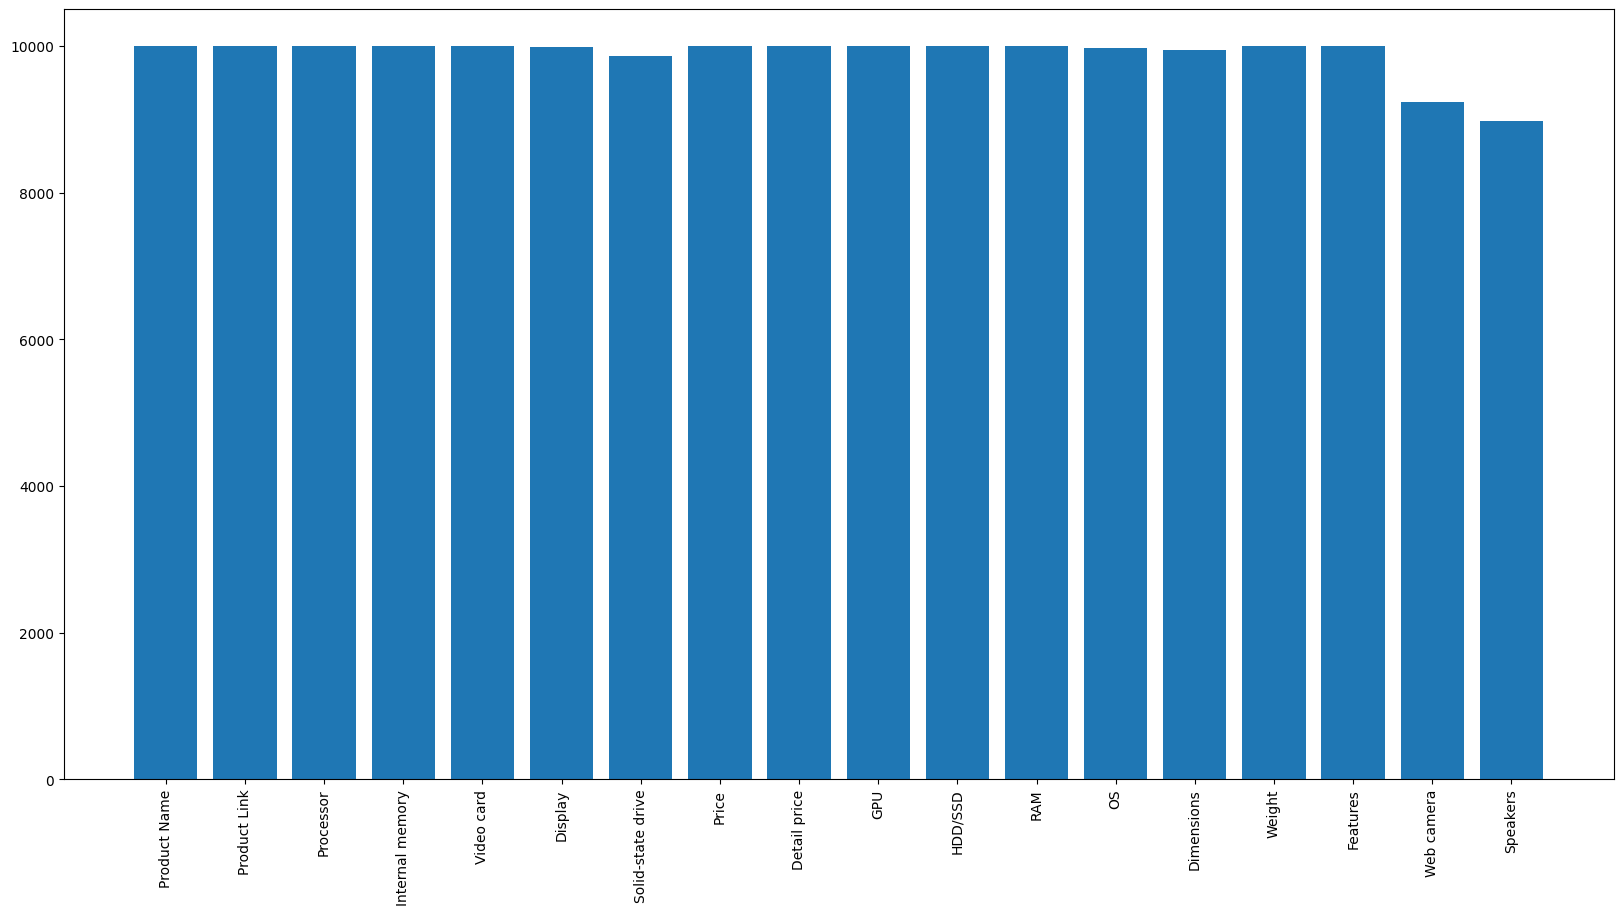

In [84]:
# plot the number of non-null values of each column
plt.figure(figsize=(20, 10))
plt.bar(data.columns, data.count())
plt.xticks(rotation=90)
plt.show()

#### 3.2.3 Chỉnh sửa thông tin và xóa đi các cột thông tin không cần thiết/ trùng lặp

- Giữ lại cột 'Solid-state-drive' và 'Hard drive' vì dữ liệu dễ xử lý và sạch hơn cột 'HDD/SSD'. Cột 'HDD/SSD' có nhiều dữ liệu không đồng nhất.

In [85]:
data['HDD/SSD'].unique()[:25]

array(['2TB SSD RAID 0', '2TB SSD RAID 1', '2TB SSD', '1TB SSD',
       '1TB SSD ', '8TB SSD', '4TB SSD', '512GB SSD',
       '512GB SSD + 1TB HDD', '256GB SSD + 1TB HDD', '2TB SSD + 2TB HDD',
       '256GB SSD', '2TB SSD ', '1TB SSD RAID 1', '128GB SSD',
       '32GB eMMC', '512GB PCIe NVMe SSD', '500GB HDD', '8TB SSD ',
       '128GB SSD + 1TB HDD', '1TB HDD', '64GB eMMC', '1TB SSD RAID 0',
       '128GB eMMC', '1TB SSD  + 2TB HDD'], dtype=object)

In [86]:
data = data.drop(columns='HDD/SSD')

- Đối với giá sản phẩm sẽ chỉ giữ lại cột 'Detail price' vì cột này có định dạng giá đúng.


In [87]:
data = data.drop(columns='Price')


- Đối với 'RAM' và 'Internal memory' sẽ giữ lại cột 'RAM' vì định dạng dữ liệu đơn giản hơn.


In [88]:
data = data.drop(columns='Internal memory')


- Giữ lại cột 'Video card' vì định dạng dữ liệu đơn giản hơn cột 'GPU'.

In [89]:
data = data.drop(columns='GPU')

- Cột 'Web camera' và 'Speakers' không có nhiều thông tin (chỉ có thông tin về tên của camera và loa) nên sẽ xóa.


In [90]:
# Some web camera values
data['Web camera'].unique()[10:25]


array(['HD with camera shutter, temporal noise reduction', 'HD or FHD',
       'HD / FHD / IR with privacy shutter, fixed focus', 'HD 720p',
       '5MP with IR', 'FHD with privacy shutter, fixed focus', '5MP',
       'HD TrueVision with temporal noise reduction', 'FHD & IR', 'HD IR',
       'FHD IR with Windows Hello', 'HD with privacy shutter',
       'FHD IR Camera for Windows Hello', 'HD + FHD', '2MP Full HD'],
      dtype=object)

In [91]:
# Some speaker values
data['Speakers'].unique()[10:25]


array(['2x 1.5W Stereo Speakers, Dolby Audio', '2 Speakers',
       '2x 2.5W Stereo Speakers', '4x Speakers, Smart Amp, Dolby Atmos',
       '2x 2W, DTS: X Ultra', 'Stereo Speakers',
       '2x 2W Speaker, Dynaudio', '2x Stereo Speakers, Acer TrueHarmony',
       '2x Speakers',
       ' 2x 2W Dual-Force Woofer + 2x 2W Tweeter, Smart Amp, Dolby Atmos',
       'Stereo Speakers, Bang & Olufsen, DTS:X Ultra',
       'Speaker System optimized by DTS Audio', '2x 2W, Dolby Audio',
       '2x 2W Speakers + 4x 2W Woofers, Dynaudio, Nahimic 3',
       '2x 1.5W, Dolby Atmos'], dtype=object)

In [92]:
data = data.drop(columns=['Web camera', 'Speakers'])


- Cuối cùng, xóa cột 'Product Link' vì không cần thiết.


In [93]:
data = data.drop(columns='Product Link')


### 3.3 Kiểm tra lại tập dữ liệu


In [94]:
data.head(10)

,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera
5,Dell Inspiron 5425,AMD Ryzen 7 5825U,"AMD Radeon RX Vega 8 (R4000/5000, 15W)","14.0"", FHD+ (1920 x 1200), IPS",1000GB SSD,$1099.99.None,16GB DDR4,Windows 11 Pro,"314 x 227.50 x 15.70 - 18.37 mm (12.36"" x 8.96...",1.55 kg (3.4 lbs),Fingerprint reader
6,Lenovo V15 Gen 2,Intel Core i7-1165G7,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$719.99.None,16GB DDR4,Windows 11 Pro,"359.2 x 235.8 x 19.9 mm (14.14"" x 9.28"" x 0.78"")",1.70 kg (3.7 lbs),Fingerprint reader
7,HP EliteBook 840 G8,Intel Core i5-1135G7,Intel Iris Xe Graphics G7 (80EU),"14.0”, Full HD (1920 x 1080), IPS",1000GB SSD,$1789.00.None,64GB DDR4,Windows 11 Pro,"323.3 x 214.6 x 17.9 mm (12.73"" x 8.45"" x 0.70"")",1.32 kg (2.9 lbs),Fingerprint reader
8,HP ENVY x360 15,Intel Core i5-1135G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, Full HD (1920 x 1080), IPS",8000GB SSD,$4649.00.None,64GB DDR4,Windows 10 Pro,"358.9 x 228 x 18.4 mm (14.13"" x 8.98"" x 0.72"")",1.82 kg (4 lbs),Fingerprint reader
9,HP 15,Intel Core i7-1260P,Intel Iris Xe Graphics G7 (96EU),"15.6”, Full HD (1920 x 1080), IPS",1000GB SSD,$989.00.None,32GB DDR4,Windows 11 Pro,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Fingerprint reader


In [95]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product Name       10000 non-null  object
 1   Processor          10000 non-null  object
 2   Video card         10000 non-null  object
 3   Display            9985 non-null   object
 4   Solid-state drive  9866 non-null   object
 5   Detail price       9997 non-null   object
 6   RAM                9998 non-null   object
 7   OS                 9975 non-null   object
 8   Dimensions         9950 non-null   object
 9   Weight             9999 non-null   object
 10  Features           9999 non-null   object
dtypes: object(11)
memory usage: 859.5+ KB


## 4. Gộp và chỉnh sửa lại dữ liệu (imputation, remove duplicates,...)


### 4.1 Gộp thông tin benchmark của CPU và GPU vào data


In [96]:
data_cpu = pd.read_csv('raw10k\cpuben.csv')
data_gpu = pd.read_csv('raw10k\gpuben.csv')

In [97]:
# Merge CPU data
data = pd.merge(data, data_cpu, left_on='Processor',
                right_on='CPU', how='left')
data.rename(columns={'Rank': 'Rank CPU'}, inplace=True)


In [98]:
data = pd.merge(data, data_gpu, left_on='Video card',
                right_on='GPU', how='left')
data.rename(columns={'Rank': 'Rank GPU'}, inplace=True)


In [99]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,CPU,Cinebench23,Rank GPU,GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,Intel Core i7-12650H,13001.0,NaN,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,Intel Core i7-12700H,15486.0,35.0,"NVIDIA GeForce RTX 3060 (Laptop, 130W)",8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,Intel Core i7-12700H,15486.0,34.0,"NVIDIA GeForce RTX 3060 (Laptop, 140W)",8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,Intel Core i7-11800H,12390.0,39.0,"NVIDIA GeForce RTX 3060 (Laptop, 105W)",8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,NaN,115.0,Intel Iris Xe Graphics G7 (80EU),1097.0


Chúng ta có thể thấy rằng có một số CPU và GPU trong data không có dữ liệu. Vì vậy, chúng ta sẽ loại bỏ hai cột này khỏi data.


In [100]:
# Delete Processor and Video card columns
# data = data.drop(columns=['Processor', 'Video card'])
data = data.drop(columns=['CPU', 'GPU'])



In [101]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,13001.0,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,15486.0,35.0,8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,15486.0,34.0,8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,12390.0,39.0,8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,115.0,1097.0


### 4.2 Xóa dữ liệu trống và trùng lặp


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product Name         10000 non-null  object 
 1   Processor            10000 non-null  object 
 2   Video card           10000 non-null  object 
 3   Display              9985 non-null   object 
 4   Solid-state drive    9866 non-null   object 
 5   Detail price         9997 non-null   object 
 6   RAM                  9998 non-null   object 
 7   OS                   9975 non-null   object 
 8   Dimensions           9950 non-null   object 
 9   Weight               9999 non-null   object 
 10  Features             9999 non-null   object 
 11  Rank CPU             8699 non-null   float64
 12  Cinebench23          8699 non-null   float64
 13  Rank GPU             8159 non-null   float64
 14  3DMark Time Spy (G)  8159 non-null   float64
dtypes: float64(4), object(11)
memory usag

In [103]:
# print number of rows that have missing values in more than 5 columns
print('Number of rows that have missing values in more than 3 columns:', data[data.isnull().sum(axis=1) > 3].shape[0])

Number of rows that have missing values in more than 3 columns: 512


In [104]:
# delete rows that have null values in more than 3 columns
data = data.dropna(thresh=data.shape[1] - 3)

In [105]:
data.shape

(9488, 15)

In [106]:
# data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)


In [107]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product Name         9327 non-null   object 
 1   Processor            9327 non-null   object 
 2   Video card           9327 non-null   object 
 3   Display              9313 non-null   object 
 4   Solid-state drive    9270 non-null   object 
 5   Detail price         9325 non-null   object 
 6   RAM                  9327 non-null   object 
 7   OS                   9308 non-null   object 
 8   Dimensions           9283 non-null   object 
 9   Weight               9327 non-null   object 
 10  Features             9327 non-null   object 
 11  Rank CPU             8551 non-null   float64
 12  Cinebench23          8551 non-null   float64
 13  Rank GPU             8019 non-null   float64
 14  3DMark Time Spy (G)  8019 non-null   float64
dtypes: float64(4), object(11)
memory usage

In [108]:
# print the sorted number of non-null values of each column
data.count().sort_values(ascending=False)


Product Name           9327
Processor              9327
Video card             9327
RAM                    9327
Weight                 9327
Features               9327
Detail price           9325
Display                9313
OS                     9308
Dimensions             9283
Solid-state drive      9270
Rank CPU               8551
Cinebench23            8551
Rank GPU               8019
3DMark Time Spy (G)    8019
dtype: int64

In [109]:
data.head()


,Product Name,Processor,Video card,Display,Solid-state drive,Detail price,RAM,OS,Dimensions,Weight,Features,Rank CPU,Cinebench23,Rank GPU,3DMark Time Spy (G)
0,ASUS TUF Dash F15,Intel Core i7-12650H,"NVIDIA GeForce RTX 3070 (Laptop, 105W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$3629.00.None,64GB DDR5,Windows 11 Pro,"354 x 251 x 19.9 - 20.7 mm (13.94"" x 9.88"" x 0...",2.00 kg (4.4 lbs),Fingerprint reader,33.0,13001.0,NaN,NaN
1,Lenovo Legion 5i 15,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 130W)","15.6”, QHD (2560 x 1440), 165 Hz, IPS",2000GB SSD,$3049.99.None,64GB DDR5,Windows 11 Pro,"358.8 x 262.35 x 19.99 - 24.05 mm (14.13"" x 10...",2.40 kg (5.3 lbs),Fingerprint reader,17.0,15486.0,35.0,8841.0
2,Acer Nitro 5,Intel Core i7-12700H,"NVIDIA GeForce RTX 3060 (Laptop, 140W)","15.6”, Full HD (1920 x 1080), 144 Hz, IPS",2000GB SSD,$1819.00.None,32GB DDR5,Windows 11 Home,"360.4 x 271.1 x 25.9 - 26.9 mm (14.19"" x 10.67...",2.50 kg (5.5 lbs),Fingerprint reader,17.0,15486.0,34.0,8864.0
3,Acer Predator Triton 500 SE,Intel Core i7-11800H,"NVIDIA GeForce RTX 3060 (Laptop, 105W)","16.0"", WQXGA (2560 x 1600), 165 Hz, IPS",1000GB SSD,$2359.99.None,32GB DDR4,Windows 10 Pro,"358.14 x 261.62 x 19.81 mm (14.10"" x 10.30"" x ...",2.44 kg (5.4 lbs),Fingerprint reader,37.0,12390.0,39.0,8290.0
4,HP 15,Intel Core i5-1155G7,Intel Iris Xe Graphics G7 (80EU),"15.6”, HD (1366 x 768), TN",2000GB SSD,$1309.99.None,64GB DDR4,Windows 11 Home,"358 x 242 x 17.9 mm (14.09"" x 9.53"" x 0.70"")",1.70 kg (3.7 lbs),Web camera,NaN,NaN,115.0,1097.0


Chúng ta thấy có một số cột dữ liệu dạng tổng hợp mà chúng ta cần phải xử lý về sau, để tránh các vấn đề trong quá trình xử lý, chúng ta sẽ xóa các dòng dữ liệu trống trong các cột này.
Các cột bao gồm:
- Display

### 4.3 Chỉnh sửa lại các cột dữ liệu


In [110]:
# create new dataframe
clean_df = pd.DataFrame()


#### 4.3.1 Chỉnh sửa thông tin giá

- **Price** : giá laptop (đơn vị: USD) là thông tin được sử dụng để dự đoán.

In [111]:
clean_df['price'] = data['Detail price'].str.extract(r'\$(\d+.\d+)')
# clean_df['price'] = data['Detail price'].str.extract(r'\$(\d+\.\d+)')
clean_df['price'] = clean_df['price'].astype('float64')


#### 4.3.2 Chỉnh sửa thông tin hãng sản xuất

- **Brand** : Laptop brand
- For example: The laptop with name 'ASUS TUF Dash F15' will have 'ASUS' brand.


In [112]:
clean_df['brand'] = data['Product Name'].str.upper().str.split().str[0]
clean_df['brand'].unique()


array(['ASUS', 'LENOVO', 'ACER', 'HP', 'DELL', 'MSI', 'ALIENWARE', 'LG',
       'APPLE', 'SAMSUNG', 'MICROSOFT', 'AORUS', 'GIGABYTE', 'RAZER',
       'PANASONIC', 'DYNABOOK', 'ENVY'], dtype=object)

#### 4.3.3 Chỉnh sửa thông tin RAM

- **RAM** : Laptop RAM
- The ram will be in the form \\{ram}{some whitespace}GB so we use this regex r'(\d+)\s\*GB' to extract it.


In [113]:
clean_df['ram'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
clean_df['ram'] = clean_df['ram'].astype('float64')
clean_df['ram'].unique()


array([ 64.,  32.,  16.,  12.,   8.,  24.,  40.,   4.,  20.,  36.,  48.,
       128.,  96.,  18.,   2.])

In [114]:

clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'(\d+)\s*GB')
# get text after GB and before , (comma) or nothing
clean_df['ram_type'] = data['RAM'].str.upper().str.extract(r'GB\s*(\w*)\,?')
# print numver of non-null value
clean_df['ram_type'].unique()


array(['DDR5', 'DDR4', 'LPDDR4X', 'LPDDR5', 'LPDDR4', 'RAM', 'LPDDR3',
       'DDR3', 'LPDDR2', ''], dtype=object)

In [115]:
clean_df['ram_type'].value_counts()

ram_type
DDR4       6984
DDR5       1480
LPDDR5      388
LPDDR4X     363
LPDDR4       62
RAM          35
LPDDR3       10
DDR3          3
LPDDR2        1
              1
Name: count, dtype: int64

Ta thấy không có loại ram nào có loại là RAM, điều này có thể vì dữ liệu cào không sạch, ta thấy số record có 'ram_type' là 'RAM' là 1. Vì vậy, ta sẽ xóa các record này.

In [116]:
# delete rows with ram_type is 'RAM'
clean_df = clean_df[clean_df['ram_type'] != 'RAM']

#### 4.3.4 Chỉnh sửa thông tin về màn hình laptop

- **Display Resolution** : Laptop display resolution
- Từ các dòng dữ liệu: "15.6”, Full HD (1920 x 1080), 144 Hz, IPS" trong cột 'Display' ta trích xuất ra thêm các thuộc tính: 
    - **'display_size'** : Kích thước màn hình laptop (inch)
    - **'display_type'** : Loại màn hình laptop (HD, Full HD, 4K, OLED, ...)
    - **'pixels'** : Độ phân giải màn hình laptop (pixels)
    - **'screen_rate'** : Tần số làm tươi màn hình laptop (Hz)
    - **'screen_panel'** : Loại panel màn hình laptop (IPS, TN, OLED, ...)


In [117]:
# tìm kiếm kích thước màn hình
clean_df['display_size'] = data['Display'].str.extract(r'^(\d+\.?\d+)')
clean_df['display_size'] = clean_df['display_size'].astype('float64')
clean_df['display_type'] = data['Display'].str.extract(r'[,](.*?)[(]')
clean_df['resolution'] = data['Display'].str.extract(r'\((.*?)\)')

clean_df['screen_rate'] = data['Display'].str.extract(r'[)][,](.*?)[H]')

clean_df['screen_panel'] = data['Display'].str.split(',').str[-1]
# remove space at the beginning and end of the string
clean_df['screen_panel'] = clean_df['screen_panel'].str.strip()


In [118]:
# print unique value of screen_panel
clean_df['screen_panel'].value_counts()

screen_panel
IPS                         7472
TN                          1566
OLED                         235
PixelSense (2256 x 1504)       3
Full HD (1920 x 1080)          2
Name: count, dtype: int64

In [119]:
clean_df['screen_panel'].unique()

array(['IPS', 'TN', 'OLED', 'PixelSense (2256 x 1504)', nan,
       'Full HD (1920 x 1080)'], dtype=object)

In [120]:
# delete rows with screen_panel is 'PixelSense (2256 x 1504)'
clean_df = clean_df[clean_df['screen_panel'] != 'PixelSense (2256 x 1504)']
# delete rows with screen_panel is 'Full HD (1920 x 1080)'
clean_df = clean_df[clean_df['screen_panel'] != 'Full HD (1920 x 1080)']


Ta thấy một số record PixelSense (2256 x 1504) Full HD (1920 x 1080) ở đây, có nghĩa là những dòng này trong dữ liệu gốc không có dữ liệu về tấm nên, do đó ta xóa các record này đi

Đối với tần số quét của laptop, thông thường mặc định các màn hình đều có tần số quét là 60Hz, nếu tần số quét cao hơn, các nhà sản xuất sẽ đưa thông tin tần số quét vào thông tin sản phẩm. Vì vậy, ta sẽ thay dữ liệu trống với tần số quét là 60Hz.

In [121]:
# fill na in screen_rate by 0
# clean_df['screen_rate'].fillna('60', inplace=True)
# trim space in screen_rate
clean_df['screen_rate'] = clean_df['screen_rate'].str.strip()
# convert screen_rate to float
clean_df['screen_rate'] = clean_df['screen_rate'].astype('float64')
clean_df['screen_rate'].unique()


array([144., 165.,  nan, 240., 120., 360., 300.,  90., 480.])

In [122]:
clean_df['display_type'].unique()

array([' Full HD ', ' QHD ', ' WQXGA ', ' HD ', ' FHD+ ', ' HD+ ',
       '  QHD ', ' WQHD ', ' WQUXGA ', ' QHD+ ', ' WUXGA ', ' WQXGA\xa0',
       ' 4K UHD ', ' WQUXGA\xa0', ' 2.5K ', ' FHD ', ' 2.2K ', ' 2.8K ',
       ' PixelSense ', ' 3.2K ', ' 3.5K ', ' UHD+ ', nan, ' 3K ',
       ' 3K2K ', ' 2K ', ' ', ' WUXGA+ ', ' WQHD+ ', ' 4K UHD+ '],
      dtype=object)

Chúng ta có thể thấy cột display_type chưa được loại bỏ khoảng trắng và ký tự đặc biệt. Vì vậy, chúng ta sẽ loại bỏ khoảng trắng và ký tự đặc biệt trong cột này. \xa0 = space

In [123]:
# trim space before and after string in display_type
clean_df['display_type'] = clean_df['display_type'].str.strip()
# change value 'Full HD' to 'FHD'
clean_df['display_type'] = clean_df['display_type'].str.replace('Full HD', 'FHD')

In [124]:
clean_df['display_type'].unique()

array(['FHD', 'QHD', 'WQXGA', 'HD', 'FHD+', 'HD+', 'WQHD', 'WQUXGA',
       'QHD+', 'WUXGA', '4K UHD', '2.5K', '2.2K', '2.8K', 'PixelSense',
       '3.2K', '3.5K', 'UHD+', nan, '3K', '3K2K', '2K', '', 'WUXGA+',
       'WQHD+', '4K UHD+'], dtype=object)

#### 4.3.5 Chỉnh sửa thông tin về kích thước laptop

- **Dimmension** : 358.9 x 228 x 18.4 mm -> kích thước của laptop bao gồm chiều dài, chiều rộng và độ dày (mm)


In [125]:
dimention = data['Dimensions'].str.findall(r'(\d+\.?\d+)')
# clean_df['length'] the first number in dimention
clean_df['length'] = dimention.str[0]
# clean_df['width'] the second number in dimention
clean_df['width'] = dimention.str[1]
# clean_df['height'] the third number in dimention
clean_df['height'] = dimention.str[2]


In [126]:
# convert to float
clean_df['length'] = clean_df['length'].astype('float64')
clean_df['width'] = clean_df['width'].astype('float64')
clean_df['height'] = clean_df['height'].astype('float64')


#### 4.3.6 Chỉnh sửa thông tin về hãng CPU và GPU

- **Processor** : CPU of laptop


In [127]:
clean_df['cpu_brand'] = data['Processor'].str.split().str[0]


In [128]:
clean_df['cpu_brand'].unique()


array(['Intel', 'AMD', 'Apple', 'Snapdragon'], dtype=object)

- **GPU** : Laptop graphic card


In [129]:
clean_df['gpu_brand'] = data['Video card'].str.upper().str.split().str[0]


In [130]:
clean_df['gpu_brand'].unique()


array(['NVIDIA', 'INTEL', 'AMD', 'APPLE', 'QUALCOMM'], dtype=object)

#### 4.3.7 Chỉnh sửa thông tin về bộ nhớ trong SSD và HDD

- **Bộ nhớ trong SSD**


In [131]:
clean_df['ssd'] = data['Solid-state drive'].str.extract(r'(\d+)\s*GB')
clean_df['ssd'] = clean_df['ssd'].astype('float64')
clean_df['ssd'].unique()


array([ 2000.,  1000.,  8000.,  4000.,   512.,   256.,   128.,    32.,
          nan,    64.,   516.,  7600.,    24.,  3000.,   120.,   250.,
       10000.,    16.,  1500., 16000., 12000.,   500.])

#### 4.3.8 Chỉnh sửa thông tin về hệ điều hành

- **OS**


In [132]:
clean_df['os'] = data['OS'].str.extract(
    r'(Windows|Linux|No OS|Mac OS|Chrome OS)')

#### 4.3.9 Chỉnh sửa thông tin về cân nặng laptop

- **Weights**


In [133]:
clean_df['weight'] = data['Weight'].str.extract(r'^(\d+\.?\d+)')
clean_df['weight'] = clean_df['weight'].astype('float64')

#### 4.3.10 Chỉnh sửa thông tin về xếp hạng và điểm hiệu năng của CPU và GPU

- CPU/ GPU benchmark


In [134]:
clean_df['cpu_point'] = data['Cinebench23']
clean_df['gpu_point'] = data['3DMark Time Spy (G)']

# convert to float
clean_df['cpu_point'] = clean_df['cpu_point'].astype('float64')
clean_df['gpu_point'] = clean_df['gpu_point'].astype('float64')


#### 4.3.11 Chỉnh sửa thông tin về các chức năng khác của laptop

- **Features**


In [135]:
clean_df['features'] = data['Features']

In [136]:
clean_df['features'].unique()


array(['Fingerprint reader', 'Web camera', 'Backlit keyboard',
       'Microphone'], dtype=object)

In [137]:
clean_df['features'].value_counts()


features
Fingerprint reader    7320
Web camera            1945
Microphone              12
Backlit keyboard        10
Name: count, dtype: int64

#### 4.3.12 Chỉnh sửa các cột dữ liệu dạng string thành uppercase

In [138]:
# conver brand, ram_type, display_type, screen_panel, cpu_brand, gpu_brand, OS to uppercase
clean_df['brand'] = clean_df['brand'].str.upper()
clean_df['ram_type'] = clean_df['ram_type'].str.upper()
clean_df['display_type'] = clean_df['display_type'].str.upper()
clean_df['screen_panel'] = clean_df['screen_panel'].str.upper()
clean_df['cpu_brand'] = clean_df['cpu_brand'].str.upper()
clean_df['gpu_brand'] = clean_df['gpu_brand'].str.upper()
clean_df['os'] = clean_df['os'].str.upper()
clean_df['features'] = clean_df['features'].str.upper()


#### 4.3.13 Xóa dữ liệu trống và trùng lặp một lần nữa

Vì chúng ta tiến hành dự đoán giá laptop, do đó, chúng ta sẽ xóa các dòng dữ liệu có giá trị 'Price' là NaN.

In [139]:
# drop missing value in Price column
clean_df.dropna(subset=['price'], inplace=True)

# clean_df.dropna(inplace=True)
clean_df.drop_duplicates(inplace=True)
# reset index column
clean_df.reset_index(drop=True, inplace=True)


## 5. Kiểm tra lại và lưu dữ liệu

In [140]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         8636 non-null   float64
 1   brand         8636 non-null   object 
 2   ram           8636 non-null   float64
 3   ram_type      8636 non-null   object 
 4   display_size  8622 non-null   float64
 5   display_type  8622 non-null   object 
 6   resolution    8622 non-null   object 
 7   screen_rate   2667 non-null   float64
 8   screen_panel  8622 non-null   object 
 9   length        8592 non-null   float64
 10  width         8588 non-null   float64
 11  height        8588 non-null   float64
 12  cpu_brand     8636 non-null   object 
 13  gpu_brand     8636 non-null   object 
 14  ssd           8579 non-null   float64
 15  os            8617 non-null   object 
 16  weight        8636 non-null   float64
 17  cpu_point     7900 non-null   float64
 18  gpu_point     7462 non-null 

In [141]:
clean_df.head()


,price,brand,ram,ram_type,display_size,display_type,resolution,screen_rate,screen_panel,length,width,height,cpu_brand,gpu_brand,ssd,os,weight,cpu_point,gpu_point,features
0,3629.00,ASUS,64.0,DDR5,15.6,FHD,1920 x 1080,144.0,IPS,354.00,251.00,19.90,INTEL,NVIDIA,2000.0,WINDOWS,2.00,13001.0,NaN,FINGERPRINT READER
1,3049.99,LENOVO,64.0,DDR5,15.6,QHD,2560 x 1440,165.0,IPS,358.80,262.35,19.99,INTEL,NVIDIA,2000.0,WINDOWS,2.40,15486.0,8841.0,FINGERPRINT READER
2,1819.00,ACER,32.0,DDR5,15.6,FHD,1920 x 1080,144.0,IPS,360.40,271.10,25.90,INTEL,NVIDIA,2000.0,WINDOWS,2.50,15486.0,8864.0,FINGERPRINT READER
3,2359.99,ACER,32.0,DDR4,16.0,WQXGA,2560 x 1600,165.0,IPS,358.14,261.62,19.81,INTEL,NVIDIA,1000.0,WINDOWS,2.44,12390.0,8290.0,FINGERPRINT READER
4,1309.99,HP,64.0,DDR4,15.6,HD,1366 x 768,NaN,TN,358.00,242.00,17.90,INTEL,INTEL,2000.0,WINDOWS,1.70,NaN,1097.0,WEB CAMERA


In [142]:
clean_df.to_csv('clean_data_10k.csv', index=False)
